# Neural Machine Translation with Attention

Advanced Learning Fall 2024.   
Last updated: 2025-01-12


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 342687407
~~~

~~~
STUDENT GIT LINK: https://github.com/Shyrelle/Adv.-computational-learning-and-data-analysis-342687407
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2024_ID_[342687407].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [ ]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from torch.utils.data import DataLoader, TensorDataset



## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, RepeatVector, Dense
import tensorflow as tf

class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

# Parameters for the model and dataset.
config = {
    'training_size': 50000,
    'digits': 4,
    'hidden_size': 128,
    'batch_size': 128,
    'epochs': 50
}

# Maximum length of input is 'int+int' or 'int-int'. Maximum length of int is DIGITS.
maxlen = config['digits'] + 1 + config['digits']

# All the numbers, plus sign and space for padding.
chars = '0123456789+- '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < config['training_size']:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, config['digits'] + 1))))
    a, b = f(), f()
    op = np.random.choice(['+', '-'])
    # Skip any addition/subtraction questions we've already seen
    # Also skip any such that x+y == y+x for addition (to reduce redundancy).
    key = (a, b, op)
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}{}{}'.format(a, op, b)
    query = q + ' ' * (maxlen - len(q))
    ans = str(a + b if op == '+' else a - b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (config['digits'] + 1 - len(ans))

    questions.append(query)
    expected.append(ans)

print('Total questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool_)
y = np.zeros((len(questions), config['digits'] + 1, len(chars)), dtype=np.bool_)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, config['digits'] + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

Generating data...
Total questions: 50000
Vectorization...


In [ ]:


model = Sequential()
model.add(LSTM(config['hidden_size'], input_shape=(maxlen, len(chars))))
model.add(RepeatVector(config['digits'] + 1))
model.add(LSTM(config['hidden_size'], return_sequences=True))
model.add(TimeDistributed(Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, config['epochs'] + 1):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=config['batch_size'],
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict(rowx)
        preds = preds.argmax(axis=-1)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct.strip() == guess.strip():
            print('☑', end=' ')
        else:
            print('☒', end=' ')
        print(guess)


Generating data...
Total questions: 50000
Vectorization...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 128)                 │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_12 (RepeatVector)      │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 5, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 5, 13)               │           1,677 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205,965 (804.55 KB)

 Trainable params: 205,965 (804.55 KB)

 Non-trainable params: 0 (0.00 B)


--------------------------------------------------
Iteration 1
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3170 - loss: 1.9967 - val_accuracy: 0.3908 - val_loss: 1.6819
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Q 1753-2    T 1751  ☒ 144  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Q 484-4409  T -3925 ☒ -4444
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Q 54+492    T 546   ☒ 104  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Q 6727+2    T 6729  ☒ 106  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Q 92-992    T -900  ☒ -188 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Q 6777-9    T 6768  ☒ 166  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Q 27+4      T 31    ☒ 11   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Q 2873-4413 T -1540 ☒ -144 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Q 5128-268  T 4860  ☒ -124 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Q 227+4011  T 4238  ☒ 1104 

--------------------------------------------------
Iteration 2
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4024 - loss: 1.6323 - val_accuracy: 0.4

1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

a)
The model shows steady improvement in accuracy during training, reaching approximately 80.67% accuracy on the training set and 75.36% on the validation set after 50 epochs. However, many predictions are incorrect or only partially correct, especially for larger or more complex numbers. Additionally, I noticed that it struggles with subtraction problems involving negative results.

b)
Sequence-to-Sequence Challenges: The model uses a simple LSTM-based encoder-decoder architecture without attention. This can cause issues, especially with long sequences or complex tasks.
Plus, he decoder's predictions depend on prior outputs, which means early mistakes can propagate and make worse predictions.

c)
I woukd Introduce an attention mechanism (for exemple Luong attention) to allow the model to dynamically focus on relevant parts of the input sequence during decoding. Plus, I would use bidirectional encoder in order to read sequences forward and backward and improve its ability to capture context for both addition and subtraction, especially with longer inputs.

d)
Yes, an attention mechanism can be applied to this model. Attention mechanisms work well with sequence-to-sequence tasks where the output depends heavily on specific parts of the input. Attention can be integrated into the decoder to dynamically focus on specific time steps in the input sequence when predicting each output step.


1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector, Dot, Activation, Concatenate

class LuongAttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongAttentionLayer, self).__init__()

    def call(self, decoder_hidden_state, encoder_outputs):
        score = Dot(axes=[2, 2])([decoder_hidden_state, encoder_outputs])

        attention_weights = Activation('softmax')(score)

        context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs])

        return context_vector, attention_weights

config = {
    'training_size': 50000,
    'digits': 4,
    'hidden_size': 128,
    'batch_size': 128,
    'epochs': 50
}

maxlen = config['digits'] + 1 + config['digits']
chars = '0123456789+- '
num_chars = len(chars)

encoder_inputs = Input(shape=(maxlen, num_chars), name="encoder_inputs")

encoder_lstm = LSTM(config['hidden_size'], return_sequences=True, return_state=True, name="encoder_lstm")
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(config['digits'] + 1, num_chars), name="decoder_inputs")
decoder_lstm = LSTM(config['hidden_size'], return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

attention_layer = LuongAttentionLayer()
context_vector, attention_weights = attention_layer(decoder_outputs, encoder_outputs)

decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

output_dense = TimeDistributed(Dense(num_chars, activation="softmax"), name="output_dense")
decoder_predictions = output_dense(decoder_combined_context)

model = Model([encoder_inputs, decoder_inputs], decoder_predictions)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

x_train_decoder = np.zeros((len(x_train), config['digits'] + 1, num_chars), dtype=np.bool_)
x_val_decoder = np.zeros((len(x_val), config['digits'] + 1, num_chars), dtype=np.bool_)

x_train_decoder[:, 1:, :] = y_train[:, :-1, :]
x_train_decoder[:, 0, chars.index(' ')] = 1
x_val_decoder[:, 1:, :] = y_val[:, :-1, :]
x_val_decoder[:, 0, chars.index(' ')] = 1

# Train the model
for iteration in range(1, config['epochs'] + 1):
    print(f"\nIteration {iteration}")
    model.fit(
        [x_train, x_train_decoder],
        y_train,
        batch_size=config['batch_size'],
        epochs=1,
        validation_data=([x_val, x_val_decoder], y_val),
    )



    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]

        decoder_input = np.zeros((1, config['digits'] + 1, len(chars)))
        decoder_input[:, 0, chars.index(' ')] = 1

        preds = model.predict([rowx, decoder_input])
        preds = preds.argmax(axis=-1)

        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ''.join(ctable.indices_char[idx] for idx in preds[0])

        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct.strip() == guess.strip():
            print('☑', end=' ')
        else:
            print('☒', end=' ')
        print(guess)



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 9, 13)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 5, 13)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_lstm (LSTM)       │ [(None, 9, 128),       │         72,704 │ encoder_inputs[0][0]   │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, 5, 128),       │         72,704 │ decoder_inputs[0][0],  │
│                           │ (None, 128), (None,    │                │ encoder_lstm[0][1],    │
│                           │ 128)]                  │                │ encoder_lstm[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ luong_attention_layer_3   │ [(None, 5, 128),       │              0 │ decoder_lstm[0][0],    │
│ (LuongAttentionLayer)     │ (None, 5, 9)]          │                │ encoder_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 5, 256)         │              0 │ luong_attention_layer… │
│ (Concatenate)             │                        │                │ decoder_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_dense              │ (None, 5, 13)          │          3,341 │ concatenate_3[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 148,749 (581.05 KB)

 Trainable params: 148,749 (581.05 KB)

 Non-trainable params: 0 (0.00 B)


Iteration 1
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.3412 - loss: 1.9391 - val_accuracy: 0.4297 - val_loss: 1.5793
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Q 506+0     T 506   ☒ 66   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Q 3555+64   T 3619  ☒ 5555 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Q 240-7416  T -7176 ☒ -24  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Q 493+807   T 1300  ☒ 1004 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Q 9024+32   T 9056  ☒ 1002 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Q 673+81    T 754   ☒ 777  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Q 346+719   T 1065  ☒ 1444 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Q 485-35    T 450   ☒ 544  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Q 28+30     T 58    ☒ 12   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Q 6-2491    T -2485 ☒ -164 

Iteration 2
352/352 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.4359 - loss: 1.5540 - val_accuracy: 0.4504 - val_loss: 1.4879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Q 708-6     T 702   ☒ 778  
1/1 ━━━━━

Model with attention: the model started with a a lower accuracy compared with the model without attention, however, it showed a consistent improvement in validation accuracy reaching a higher performance level as its interations increased. The accuracy is aroud 85% at iteration 50. The loss is equal to 0.399

Model without attention: achieved quicker initial gains accuracy but plateaued sooner. The accuracy is around 80%. The loss is around 0.52.

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [ ]:
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

SOLUTION:

In [ ]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(config['device'])
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(config['device'])
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).to(config['device'])
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(config['device'])
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

In [ ]:

config = {
    "training_size": 40000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "iterations": 50,
    "input_size": len(chars),
    "output_size": len(chars),
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super(LuongAttention, self).__init__()
        self.attn = nn.Linear(hidden_size + (hidden_size * 2), hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, decoder_hidden_step, encoder_outputs):
        batch_size, seq_len, _ = encoder_outputs.shape
        decoder_hidden_expanded = decoder_hidden_step.expand(-1, seq_len, -1)
        combined = torch.cat((decoder_hidden_expanded, encoder_outputs), dim=2)
        scores = self.v(torch.tanh(self.attn(combined)))
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.sum(attn_weights * encoder_outputs, dim=1, keepdim=True)
        return context, attn_weights

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder_embedding = nn.Linear(input_size, hidden_size)
        self.decoder_embedding = nn.Linear(input_size, hidden_size)
        self.encoder = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        self.decoder_init = nn.Linear(hidden_size * 2, hidden_size)
        self.decoder = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=False)
        self.attention = LuongAttention(hidden_size)
        self.fc = nn.Linear(hidden_size * 3, output_size)

    def forward(self, encoder_input, decoder_input):
        enc_embed = self.encoder_embedding(encoder_input)
        encoder_outputs, (hidden, cell) = self.encoder(enc_embed)
        hidden = torch.cat((hidden[0], hidden[1]), dim=1)
        cell = torch.cat((cell[0], cell[1]), dim=1)
        hidden = self.decoder_init(hidden).unsqueeze(0)
        cell = self.decoder_init(cell).unsqueeze(0)
        dec_embed = self.decoder_embedding(decoder_input)
        decoder_outputs, _ = self.decoder(dec_embed, (hidden, cell))
        attention_outputs = []
        batch_size, seq_len, _ = decoder_outputs.shape
        for t in range(seq_len):
            decoder_step = decoder_outputs[:, t, :].unsqueeze(1)
            context, _ = self.attention(decoder_step, encoder_outputs)
            attention_outputs.append(context)
        attention_outputs = torch.cat(attention_outputs, dim=1)
        combined = torch.cat((decoder_outputs, attention_outputs), dim=-1)
        outputs = self.fc(combined)
        return outputs

model = Seq2SeqWithAttention(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["output_size"]
).to(config["device"])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = config["iterations"]

def calculate_sequence_accuracy(logits, targets):
    preds = logits.argmax(dim=-1)
    tars = targets.argmax(dim=-1)
    correct_sequences = (preds == tars).all(dim=1)
    accuracy = correct_sequences.float().mean()
    return accuracy.item()

for epoch in range(1, epochs + 1):
    print(f"\nepoch {epoch} ━━━━━━━━━━━━━━━━━━━━━━")
    model.train()
    epoch_loss, correct_total, total_count = 0, 0, 0

    for encoder_input, decoder_target in train_loader:
        encoder_input, decoder_target = encoder_input.to(config["device"]), decoder_target.to(config["device"])
        decoder_input = torch.zeros_like(decoder_target)
        decoder_input[:, 1:, :] = decoder_target[:, :-1, :]
        decoder_input[:, 0, chars.index(' ')] = 1

        optimizer.zero_grad()
        outputs = model(encoder_input, decoder_input)
        batch_size, seq_len, vocab = outputs.shape
        loss = criterion(
            outputs.view(-1, vocab),
            decoder_target.argmax(dim=-1).view(-1)
        )
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        acc = calculate_sequence_accuracy(outputs, decoder_target)
        correct_total += acc * batch_size
        total_count += batch_size

    print(f"Loss: {epoch_loss:.4f} | Accuracy: {100.0 * correct_total / total_count:.2f}%")

    model.eval()
    with torch.no_grad():
        for i in range(10):
            ind = np.random.randint(0, len(x_val))
            rowx = x_val_tensor[ind].unsqueeze(0)
            rowy = y_val_tensor[ind].unsqueeze(0)
            dec_in = torch.zeros((1, config["digits"] + 1, config["input_size"]), dtype=torch.float32).to(config["device"])
            dec_in[:, 0, chars.index(' ')] = 1
            out = model(rowx, dec_in)
            out = out.argmax(dim=-1).cpu().numpy()
            q = ctable.decode(rowx.cpu().numpy()[0])
            correct = ctable.decode(rowy.cpu().numpy()[0])
            guess = ''.join(ctable.indices_char[idx] for idx in out[0])
            print(f"Q {q:<10} T {correct:<10} {'☑' if correct.strip() == guess.strip() else '☒'} {guess}")



epoch 1 ━━━━━━━━━━━━━━━━━━━━━━
Loss: 543.3746 | Accuracy: 1.17%
Q 771-7      T 764        ☒ 77   
Q 1+590      T 591        ☒ 590  
Q 87+66      T 153        ☒ 11   
Q 98+30      T 128        ☒ 100  
Q 7933-4514  T 3419       ☒ 1133 
Q 7989+39    T 8028       ☒ 7933 
Q 8656-810   T 7846       ☒ 8033 
Q 7718+81    T 7799       ☒ 7703 
Q 688+672    T 1360       ☒ 123  
Q 9957-337   T 9620       ☒ 9033 

epoch 2 ━━━━━━━━━━━━━━━━━━━━━━
Loss: 379.4119 | Accuracy: 5.76%
Q 1-3339     T -3338      ☒ -339 
Q 6426+15    T 6441       ☒ 6438 
Q 924+5456   T 6380       ☒ 5511 
Q 4920+8350  T 13270      ☒ 1110 
Q 22-844     T -822       ☒ --9  
Q 14-595     T -581       ☒ -52  
Q 34+1833    T 1867       ☒ 1838 
Q 2430+30    T 2460       ☒ 2430 
Q 0-2648     T -2648      ☒ -644 
Q 25-0       T 25         ☑ 25   

epoch 3 ━━━━━━━━━━━━━━━━━━━━━━
Loss: 338.2544 | Accuracy: 7.74%
Q 490-4400   T -3910      ☒ -200 
Q 4+6405     T 6409       ☒ 6408 
Q 52+49      T 101        ☒ 12   
Q 34-59      T -25     

The Pytorch network reaches an accurary of 97% at the last epoch compared to 85% in the prevvious network which is a significant improvment.

I thought using PyTorch Model in bidirectional LSTM for the encoder, capturing forward and backward context. the PyTorch model’s bidirectional LSTM and attention help it improve the performence the TensorFlow model in terms of both final accuracy and training speed.

---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



Bahdanau attention computes attention scores using a feed-forward neural network that combines the decoder's hidden state and the encoder's outputs. In contrast, Luong attention, referred to as multiplicative attention, calculates attention scores by taking the dot product between the decoder's hidden state and the encoder's outputs. This difference in computation leads to Bahdanau attention being more flexible but computationally intensive, while Luong attention is more efficient but may be less effective in capturing complex alignments.


1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


In [10]:
!unzip -o /content/heb-eng.zip -d /content/


Archive:  /content/heb-eng.zip
  inflating: /content/_about.txt     
  inflating: /content/heb.txt        


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

In [5]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    """Normalize the sentences by removing metadata and cleaning text."""
    s = re.sub(r"CC-BY.*", "", s)  # Remove metadata starting with "CC-BY"
    s = s.strip()
    s = re.sub(r"[^a-zA-Zא-ת\s]", "", s)  # Keep letters and spaces only
    return s.lower().strip()


In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('heb.txt', encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


def filterPair(p):
    """Filter sentence pairs by length and prefixes."""
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    """Apply filtering to all pairs."""
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [11]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'heb', True)
print(random.choice(pairs))

Reading lines...
Read 128133 sentence pairs
Trimmed to 1713 sentence pairs
Counting words...
Counted words:
heb 2103
eng 1278
['הוא סופר בעל דמיון רב', 'he is a very imaginative writer']


In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [14]:


class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):

    global SOS_token, EOS_token
    SOS_token = 0
    EOS_token = 1

    input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [16]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [17]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [18]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [19]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [20]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [21]:
def evaluateRandomly(encoder, decoder, n=20):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [23]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 128133 sentence pairs
Trimmed to 1713 sentence pairs
Counting words...
Counted words:
heb 2103
eng 1278
0m 6s (- 1m 41s) (5 6%) 2.4874
0m 13s (- 1m 31s) (10 12%) 1.5531
0m 18s (- 1m 21s) (15 18%) 1.0885
0m 25s (- 1m 15s) (20 25%) 0.7715
0m 30s (- 1m 7s) (25 31%) 0.5348
0m 37s (- 1m 1s) (30 37%) 0.3565
0m 42s (- 0m 54s) (35 43%) 0.2276
0m 48s (- 0m 48s) (40 50%) 0.1422
0m 54s (- 0m 42s) (45 56%) 0.0901
1m 1s (- 0m 36s) (50 62%) 0.0595
1m 6s (- 0m 30s) (55 68%) 0.0412
1m 13s (- 0m 24s) (60 75%) 0.0301
1m 18s (- 0m 18s) (65 81%) 0.0239
1m 24s (- 0m 12s) (70 87%) 0.0200
1m 30s (- 0m 6s) (75 93%) 0.0172
1m 36s (- 0m 0s) (80 100%) 0.0143


In [24]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> הוא לץ רציני
= he is a big prankster
< he is a big prankster <EOS>

> אני לא מכיר אותו
= i am not acquainted with him
< i am not acquainted him him theater theater theater theater

> הוא לא מתאים להיות מורה
= he is unfit to be a teacher
< he is unfit to be a teacher <EOS>

> הוא בבית היום
= he is at home today
< he is at home today <EOS>

> הביקורת שלו גומזת
= he is a harsh critic
< he is a harsh critic <EOS>

> הוא חסר ניסיון
= he is lacking in experience
< he is lacking handsome salary salary salary salary salary salary

> את תמיד מתלוננת
= you are always complaining
< you are difficult difficult difficult belt extremely flying flying flying

> אני בת אדם
= i am human
< i am human <EOS>

> אני משחק בקבוצת הכדורסל
= i am a member of the basketball team
< i am a member of the basketball team club help

> היא די מרוצה מעבודתה החדשה
= she is quite satisfied with her new job
< she is quite satisfied with her new job new job

> היא אוהבת בעלי חיים
= she is fond of animals
< she is fond o

input = הוא בן ארבעים לערך
output = he is about forty <EOS>


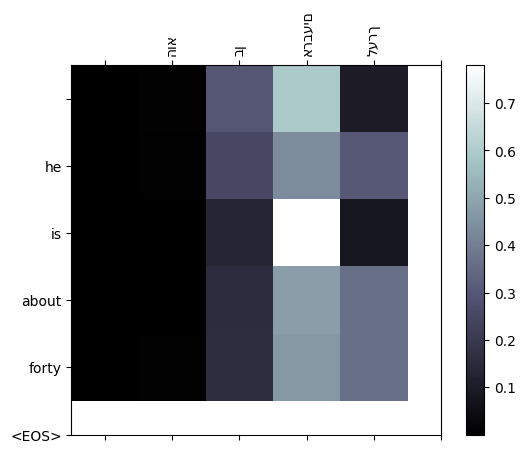

input = הוא בר סמכא בפיזיקה
output = he is an authority on physics physics salary <EOS>


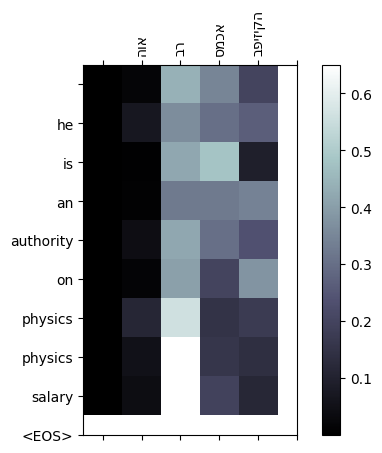

input = הוא לא לגמרי טועה
output = he is not altogether wrong salary salary salary amicably recover


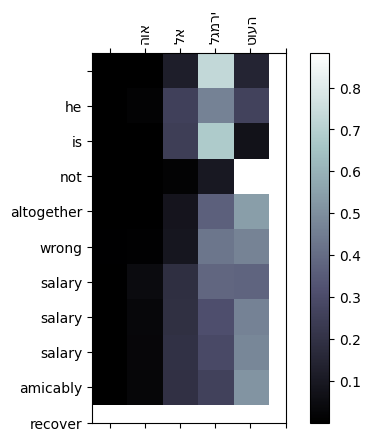

input = הוא אינו רופא אלא מורה
output = he is not a doctor but a doctor but a


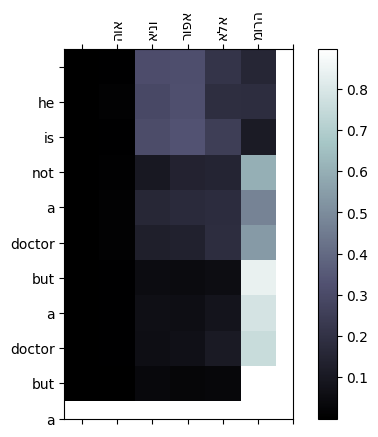

input = אני מעורה בסוגיה הזו
output = i am familiar things familiar him refreshed refreshed refreshed open


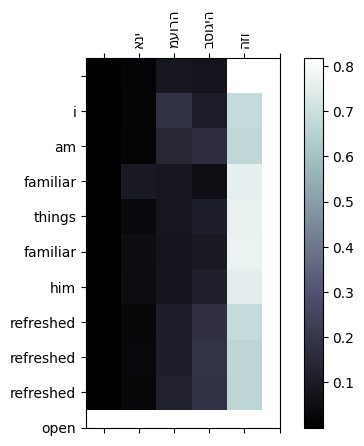

In [25]:
from IPython.display import display

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    input_labels = [''] + input_sentence.split(' ') + ['']
    ax.set_xticks(np.arange(len(input_labels)))
    ax.set_yticks(np.arange(len(output_words) + 1))
    ax.set_xticklabels(input_labels, rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    display(fig)
    plt.close(fig)



def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

for _ in range(5):
    pair = random.choice(pairs)
    input_sentence = pair[0]
    evaluateAndShowAttention(input_sentence)



3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


The model's performance is mixed. Ineed, it can translates some basic sentences reasonably however, it still has significant limitations, especially with longer sentences, it struggles with more complex sentences or words outside of its limited vocabulary and it often makes grammatical errors or produces translations that are not perfectly idiomatic. Also, it produces many errors, ranging from incomplete translations to incorrect words and extra words that do not belong.
To improve the model I would moove forward transformers and use Luong Attention.



4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [1]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

SOLUTION:

In [23]:

batch_size = 32
teacher_forcing_ratio = 0.85
beam_width = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_token = 0
EOS_token = 1

class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super(LuongAttention, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        scores = torch.bmm(encoder_outputs, decoder_hidden.permute(1, 2, 0))
        attn_weights = F.softmax(scores.squeeze(2), dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        return context, attn_weights

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, input):
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded)
        return self.layer_norm(output), hidden

class LuongAttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(LuongAttnDecoder, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = LuongAttention(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.4)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None, epoch=0):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.full((batch_size, 1), SOS_token, dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden
        decoder_outputs, attentions = [], []

        use_teacher_forcing = random.random() < (teacher_forcing_ratio - (epoch * 0.015))

        for i in range(MAX_LENGTH):
            embedded = self.dropout(self.embedding(decoder_input))
            context, attn_weights = self.attention(decoder_hidden, encoder_outputs)
            rnn_input = torch.cat((embedded, context), dim=2)
            output, decoder_hidden = self.gru(rnn_input, decoder_hidden)
            output = self.out(output)
            decoder_outputs.append(output)
            attentions.append(attn_weights)

            _, topi = output.topk(1)
            decoder_input = target_tensor[:, i].unsqueeze(1) if (target_tensor is not None and use_teacher_forcing) else topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        return decoder_outputs, decoder_hidden, attentions

def beam_search(decoder_outputs):
    sequences = [[[], 0.0]]
    for t in range(MAX_LENGTH):
        all_candidates = []
        for seq, score in sequences:
            probs, topi = decoder_outputs[:, t].topk(beam_width)
            for i in range(beam_width):
                new_seq = seq + [topi[0][i].item()]
                new_score = score + probs[0][i].item()
                all_candidates.append((new_seq, new_score))
        sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
    return sequences[0][0]

def train(train_dataloader, encoder, decoder, n_epochs=80, learning_rate=0.001, print_every=5):
    encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate, weight_decay=1e-4)
    decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        total_loss = 0
        for input_tensor, target_tensor in train_dataloader:
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor, epoch)

            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)

            encoder_optimizer.step()
            decoder_optimizer.step()

            total_loss += loss.item()

        if epoch % print_every == 0:
            print(f"Epoch {epoch}/{n_epochs}, Loss: {total_loss / len(train_dataloader):.4f}")
    print("Training Complete!")

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = torch.LongTensor([input_lang.word2index.get(word, EOS_token) for word in sentence.split(' ')] + [EOS_token]).view(1, -1).to(device)
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        best_sequence = beam_search(decoder_outputs)
        decoded_words = [output_lang.index2word[idx] for idx in best_sequence if idx != EOS_token]
    return decoded_words, decoder_attn

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)
encoder = Encoder(input_lang.n_words, hidden_size).to(device)
decoder = LuongAttnDecoder(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, n_epochs=epochs, print_every=5)
evaluateRandomly(encoder, decoder)


Reading lines...
Read 128133 sentence pairs
Trimmed to 1713 sentence pairs
Counting words...
Counted words:
heb 2103
eng 1278
Epoch 5/50, Loss: 2.1906
Epoch 10/50, Loss: 1.7990
Epoch 15/50, Loss: 1.6251
Epoch 20/50, Loss: 1.4376
Epoch 25/50, Loss: 1.2027
Epoch 30/50, Loss: 0.9926
Epoch 35/50, Loss: 0.7477
Epoch 40/50, Loss: 0.5417
Epoch 45/50, Loss: 0.3691
Epoch 50/50, Loss: 0.2382
Training Complete!
> אני אוהב מכוניות
= i am fond of cars
< i am fond of playing both SOS SOS SOS

> עליך להגיש את העבודות שלך עד יום ב
= you are to hand in your assignments by monday
< you are saying you to hand your assignments monday monday

> אני רעב נורא
= i am terribly hungry
< i am terribly hungry i did not SOS SOS

> אני בן שמונה עשרה
= i am eighteen years old
< i am eighteen years old SOS SOS SOS SOS

> הוא מזדקן
= he is getting old
< he is not here SOS SOS SOS SOS SOS

> הוא נחוש להצליח
= he is eager for success
< he is eager for success SOS SOS SOS SOS

> את שיכורה
= you are drunk
< you are deceiv

We can see that using Luong attention has improved our model getting a better translation. I thought about using Luong attention because it is more computationally efficient than Bahdanau.

In [ ]:
!jupyter nbconvert --to html /content/NOTEBOOKFILE.ipynb